In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, merge, Dot
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence

import urllib
import collections
import os
import zipfile

import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def maybe_download(filename, url, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename


# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

def collect_data(vocabulary_size=10000):
    url = 'http://mattmahoney.net/dc/'
    filename = maybe_download('text8.zip', url, 31344016)
    vocabulary = read_data(filename)
    print(vocabulary[:7])
    data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)
    del vocabulary  # Hint to reduce memory.
    return data, count, dictionary, reverse_dictionary

In [3]:
vocab_size = 10000
data, count, dictionary, reverse_dictionary = collect_data(vocabulary_size=vocab_size)
print(data[:7])

Found and verified text8.zip
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse']
[5234, 3081, 12, 6, 195, 2, 3134]


In [4]:
window_size = 3
vector_dim = 300
epochs = 200

valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(data, vocab_size, window_size=window_size, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples[:10], labels[:10])

[[1699, 524], [7538, 4563], [799, 7767], [3906, 1698], [403, 7482], [7358, 1], [3815, 524], [11, 9674], [6198, 6], [9703, 251]] [1, 1, 0, 0, 0, 1, 0, 1, 1, 1]


In [5]:
# create some input variables
input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')
target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

# setup a cosine similarity operation which will be output in a secondary model
similarity = merge.dot([target, context], axes=0, normalize=True, name='similarity')

# now perform the dot product operation to get a similarity measure
dot_product = merge.dot([target, context], axes=1, name='dot')
dot_product = Reshape((1,))(dot_product)
# add the sigmoid output layer
output = Dense(1, activation='sigmoid', name='sigmoid')(dot_product)
# create the primary training model
model = Model(input=[input_target, input_context], output=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

/Users/duoan/.pyenv/versions/miniconda3-4.3.30/envs/recsys/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("si...)`


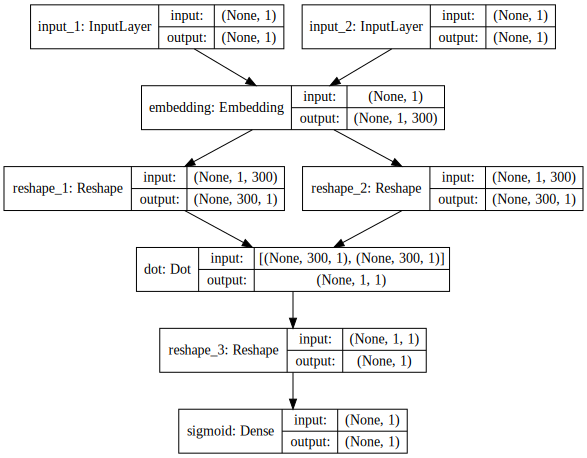

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [7]:
# create a secondary validation model to run our similarity checks during training
validation_model = Model(input=[input_target, input_context], output=similarity)

/Users/duoan/.pyenv/versions/miniconda3-4.3.30/envs/recsys/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("si...)`
  


In [8]:
class SimilarityCallback:
    def run_sim(self):
        for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8  # number of nearest neighbors
            sim = self._get_sim(valid_examples[i])
            nearest = (-sim).argsort()[1:top_k + 1]
            log_str = 'Nearest to %s:' % valid_word
            for k in range(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = '%s %s,' % (log_str, close_word)
            print(log_str)

    @staticmethod
    def _get_sim(valid_word_idx):
        sim = np.zeros((vocab_size,))
        in_arr1 = np.zeros((1,))
        in_arr2 = np.zeros((1,))
        in_arr1[0,] = valid_word_idx
        for i in range(vocab_size):
            in_arr2[0,] = i
            out = validation_model.predict_on_batch([in_arr1, in_arr2])
            sim[i] = out
        return sim
sim_cb = SimilarityCallback()

In [9]:
arr_1 = np.zeros((1,))
arr_2 = np.zeros((1,))
arr_3 = np.zeros((1,))
for cnt in range(epochs):
    idx = np.random.randint(0, len(labels)-1)
    arr_1[0,] = word_target[idx]
    arr_2[0,] = word_context[idx]
    arr_3[0,] = labels[idx]
    loss = model.train_on_batch([arr_1, arr_2], arr_3)
    if cnt % 100 == 0:
        print("Iteration {}, loss={}".format(cnt, loss))
    if cnt % 10000 == 0:
        sim_cb.run_sim()

Iteration 0, loss=0.6866509318351746
Nearest to th: etruscan, macau, fertile, functions, usage, peacekeeping, excel, earlier,
Nearest to if: alchemy, upgraded, facts, winners, las, garfield, offspring, teacher,
Nearest to years: oldest, crystalline, based, important, observable, officially, visiting, os,
Nearest to most: emphasis, demonstrations, suggests, thou, copied, sheet, convention, instructions,
Nearest to had: ny, asian, recommended, presumably, seeks, midnight, holdings, guinea,
Nearest to about: enforce, crucial, sects, murray, algorithms, borne, fighting, nintendo,
Nearest to after: bigger, lou, remote, invaded, fitzgerald, feel, capitals, planes,
Nearest to many: assume, boat, elevated, sworn, socially, combination, appear, significance,
Nearest to people: fractal, soldiers, several, rhetoric, colspan, provisions, honey, oriental,
Nearest to between: rock, seems, everywhere, critical, cos, volunteer, revenues, avoiding,
Nearest to for: foods, element, masturbation, wake, re